In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xgamecare2025/xgamecare2025.csv


# Load Packages

In [3]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
import missingno as msno

#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import clone

#algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,  f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer, mean_squared_error



# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
import shap

random_state = 42
np.random.seed(42)
random.seed(42)


# Look at Data

In [4]:
# 1. Load the Data
original_train_df = pd.read_csv("/kaggle/input/xgamecare2025/xgamecare2025.csv")

# Copy the Dataset 
pipe_data = original_train_df.copy()

# Dataset used for analysis
train_df = original_train_df.copy()
train_df.head()

,Sex,Age,Previous experience,Hearing problems,Education level,BMI,Care level,QMCI,4-m Gait Test,Chair Test,...,Verbal Support Cloudy,Verbal Support Lumina,Verbal Support Hexagon,Verbal Support Evolve,Verbal Support Flexi,Verbal Support Drops,Verbal Support Simon,Verbal Support React,Verbal Support Arrows,Verbal Support Flaneur
0,w,89.0,No,Yes,9.0,18.0,6.0,13.5,"6,21 - 8,7 s","≥ 16,7 s",...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3
1,w,84.0,No,No,10.0,23.1,5.0,43.5,"6,21 - 8,7 s","> 60 s, oder Aufgabe nicht bewältigt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,w,92.0,No,Yes,11.0,25.4,2.0,9.0,"6,21 - 8,7 s","13,70 - 16,69 s",...,1.0,1.0,3.0,NaN,NaN,3.0,3.0,NaN,3.0,1
3,w,89.0,No,No,16.0,28.4,2.0,52.0,"4, 82 - 6,20 s","11,2 - 13,69 s",...,NaN,NaN,3.0,1.0,1.0,3.0,3.0,1.0,2.0,1
4,m,95.0,No,No,9.0,24.2,7.0,56.5,"> 8,7 s","> 60 s, oder Aufgabe nicht bewältigt",...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0


In [5]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           100 non-null    object 
 1   Age                           99 non-null     float64
 2   Previous experience           100 non-null    object 
 3   Hearing problems              100 non-null    object 
 4   Education level               74 non-null     float64
 5   BMI                           62 non-null     float64
 6   Care level                    85 non-null     float64
 7   QMCI                          99 non-null     float64
 8   4-m Gait Test                 100 non-null    object 
 9   Chair Test                    100 non-null    object 
 10  SPPB                          100 non-null    float64
 11  Rocket                        100 non-null    object 
 12  Simple                        99 non-null     object 
 13  Divide

In [6]:
train_df[['Sex', 'Age', 'Previous experience', 'Education level', 'BMI',
    'Care level', 'QMCI', 'SPPB',
     "Mobility Aids"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,99.0,86.616162,6.873058,65.00,82.000,88.0,92.0000,99.0
Education level,74.0,10.270270,2.336707,6.00,9.000,9.0,11.0000,16.0
BMI,62.0,25.338710,5.490361,14.76,21.425,24.5,28.3925,40.3
Care level,85.0,4.752941,2.506686,1.00,3.000,5.0,6.0000,10.0
QMCI,99.0,38.474747,17.914248,5.00,24.750,39.0,52.2500,77.5
SPPB,100.0,5.530000,2.516431,0.00,4.000,5.0,7.0000,11.0


In [7]:
cols = ['Sex', 'Previous experience', 'Hearing problems', 'Mobility Aids']

percent_table = train_df[cols].apply(lambda x: x.value_counts(normalize=True) * 100)
percent_table


,Sex,Previous experience,Hearing problems,Mobility Aids
Cane,NaN,NaN,NaN,5.0
No,NaN,64.0,81.0,NaN
Nothing,NaN,NaN,NaN,33.0
Walker with Wheels,NaN,NaN,NaN,55.0
Walking Frame,NaN,NaN,NaN,1.0
Wheelchair,NaN,NaN,NaN,6.0
Yes,NaN,36.0,19.0,NaN
m,29.0,NaN,NaN,NaN
w,71.0,NaN,NaN,NaN


# Prepare Dataset
* Sorting of the columns into features and game columns
* Ordinal Encoding
* Greate new Feature Game (1 Dataentry per Game per Participant)

In [8]:
# List of games
games = ['Rocket', 'Simple', 'Divided', 'Birds', 'Habitats', 'Snake', 'Targets', 'Sams Garden',
         'Ladybug', 'Ski', 'Cloudy', 'Lumina', 'Hexagon', 'Evolve', 'Flexi', 'Drops', 'Simon',
         'React', 'Arrows', 'Flaneur']

# List of Features
participant_cols = [
    'Sex','Age', 'Previous experience', 'Education level', 'BMI',
    'Care level', 'QMCI', '4-m Gait Test', 'Chair Test',
     "Mobility Aids", "Balance Test"

]

#Ordinal Encoding
mapping_mobility = {"Nothing": 0, "Cane": 1, "Walker with Wheels": 1,
                    "Walking Frame": 1, "Wheelchair": 1}
mapping_walking = {"Gehstrecke nicht bewältigt": 0, "> 8,7 s": 1,"6,21 - 8,7 s": 2, "4, 82 - 6,20 s": 3 ,"< 4,82 s": 4}
mapping_standing = {'> 60 s, oder Aufgabe nicht bewältigt': 0, '≥ 16,7 s': 1, '13,70 - 16,69 s': 2, '11,2 - 13,69 s': 3, '≤ 11,19 s': 4}
for m in (mapping_mobility, mapping_walking, mapping_standing):
    train_df.replace(m, inplace=True)


# Assign a Participant_ID if not already present
train_df['Participant_ID'] = train_df.index

# Create long-form data 
rows = []
for idx, row in train_df.iterrows():
    for game in games:
        rows.append({
            'Participant_ID': idx,
            'Game': game,
            'Gameplay': row.get(game),
            'Physical Support': row.get(f'Physical Support {game}', None),
            'Verbal Support': row.get(f'Verbal Support {game}', None),
            **{col: row[col] for col in participant_cols}
        })

# Convert to DataFrame
train_df = pd.DataFrame(rows)

In [9]:
train_df.head(5)

,Participant_ID,Game,Gameplay,Physical Support,Verbal Support,Sex,Age,Previous experience,Education level,BMI,Care level,QMCI,4-m Gait Test,Chair Test,Mobility Aids,Balance Test
0,0,Rocket,Yes,1.0,2.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
1,0,Simple,Yes,1.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
2,0,Divided,No,3.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
3,0,Birds,Yes,1.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
4,0,Habitats,No,3.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0


In [10]:
train_df.shape

(2000, 16)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Participant_ID       2000 non-null   int64  
 1   Game                 2000 non-null   object 
 2   Gameplay             1593 non-null   object 
 3   Physical Support     1593 non-null   float64
 4   Verbal Support       1593 non-null   float64
 5   Sex                  2000 non-null   object 
 6   Age                  1980 non-null   float64
 7   Previous experience  2000 non-null   object 
 8   Education level      1480 non-null   float64
 9   BMI                  1240 non-null   float64
 10  Care level           1700 non-null   float64
 11  QMCI                 1980 non-null   float64
 12  4-m Gait Test        2000 non-null   int64  
 13  Chair Test           2000 non-null   int64  
 14  Mobility Aids        2000 non-null   int64  
 15  Balance Test         2000 non-null   f

In [12]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
BMI,760,38.000000
Education level,520,26.000000
Gameplay,407,20.350000
Physical Support,407,20.350000
Verbal Support,407,20.350000
Care level,300,15.000000
Age,20,1.000000
QMCI,20,1.000000


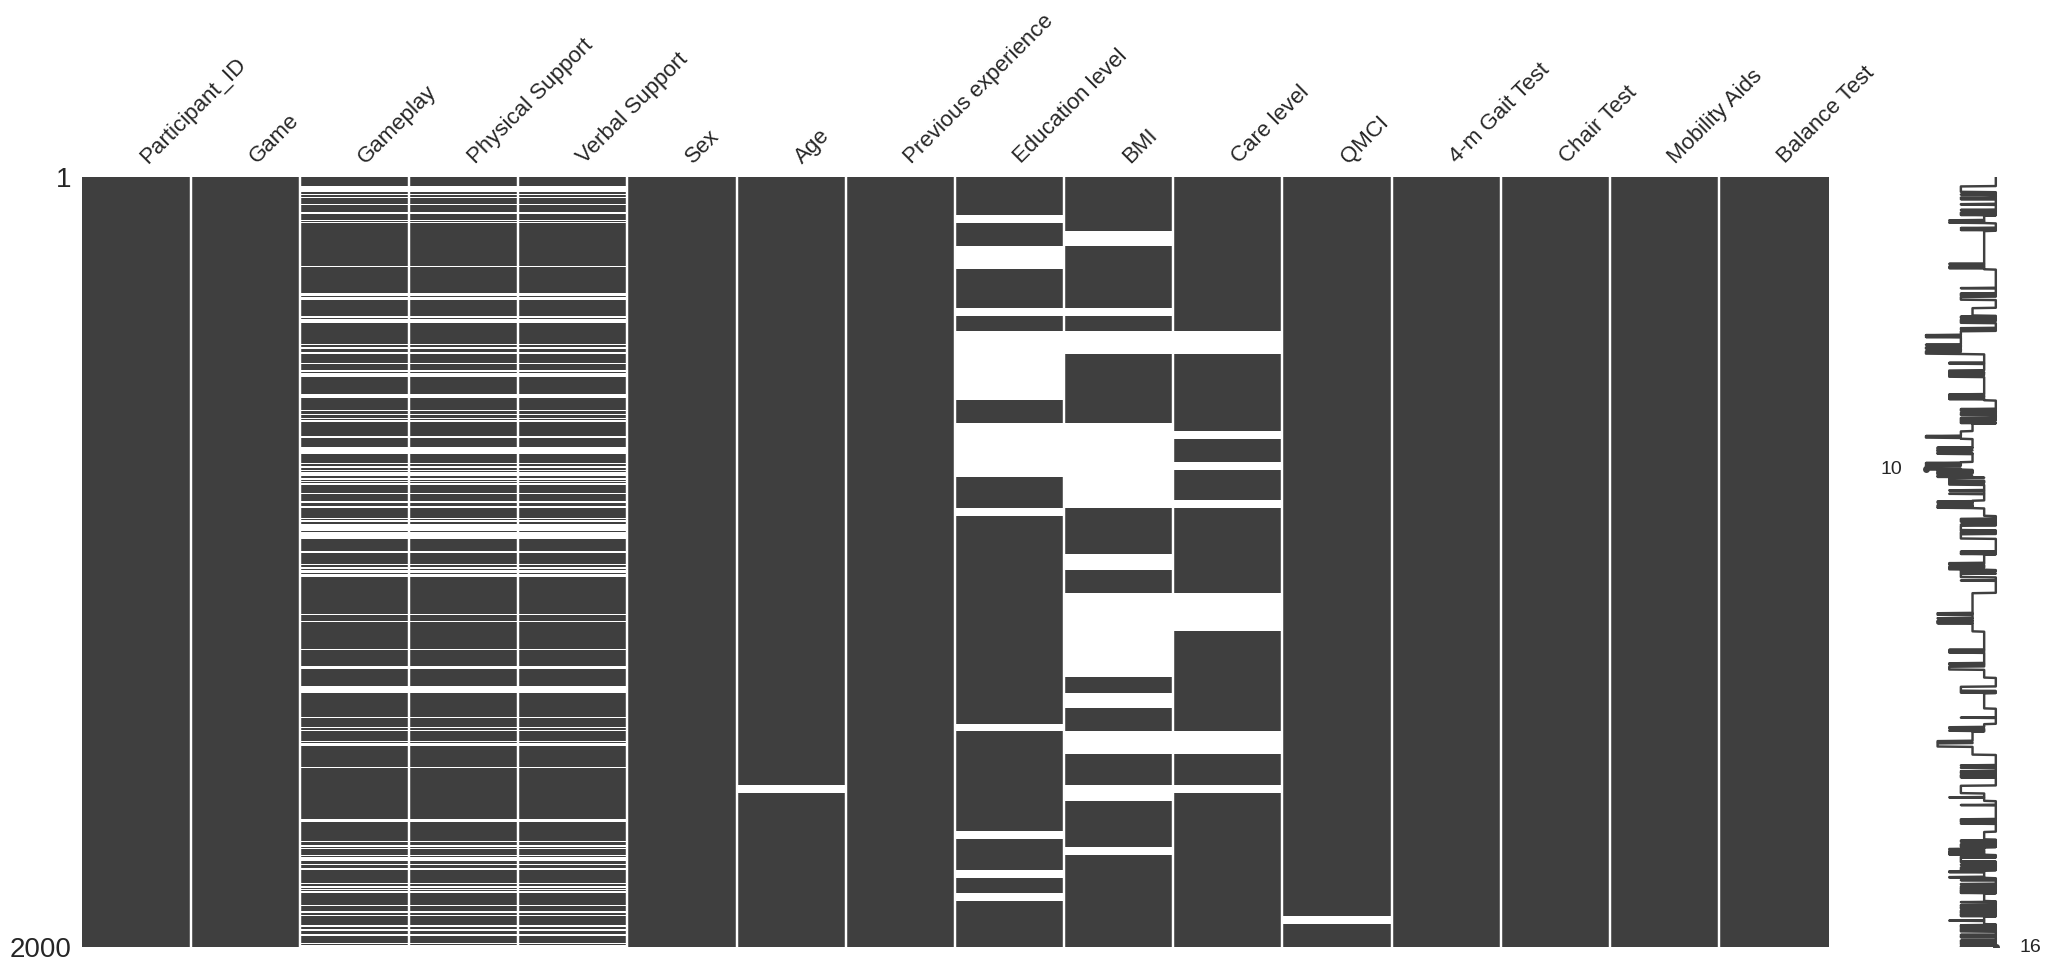

In [13]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

In [14]:
#There is no point having missings on target
train_df = train_df.dropna(subset=["Gameplay"])

In [15]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,count,percent
BMI,628,39.422473
Education level,425,26.679222
Care level,243,15.254237
Age,20,1.255493
QMCI,19,1.192718


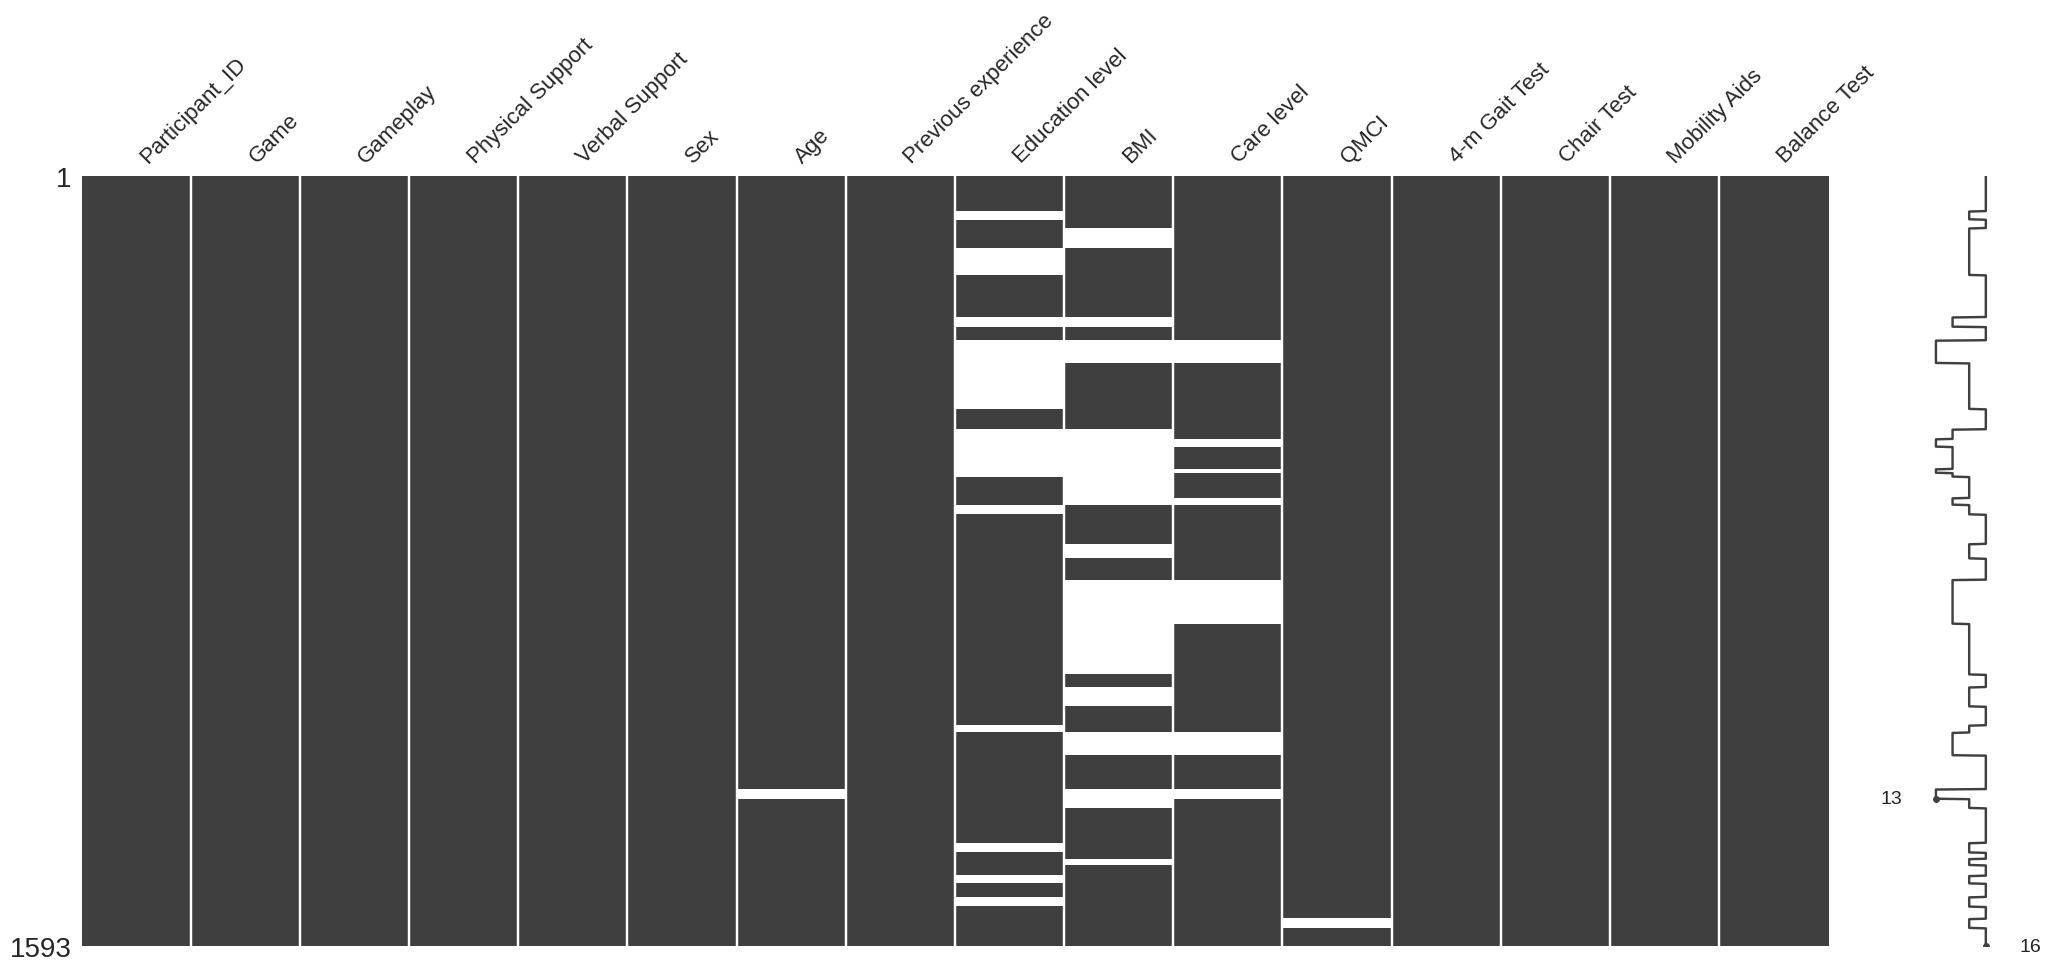

In [16]:
msno.matrix(train_df)
plt.show()

In [17]:
target_game = "Gameplay"
train_df[target_game] = train_df[target_game].map({'Yes': 1, 'No': 0})

# Define dynamic feature column names
physical_col = "Physical Support"
verbal_col = "Verbal Support"
game_col = target_game  # this is the original target column in your dataset


# Create the combined class code column
train_df["Combined_Class_Code"] = (
    (train_df[physical_col] > 0).astype(int).astype(str) +
    (train_df[verbal_col] > 0).astype(int).astype(str) +
    train_df[game_col].astype(int).astype(str)
)

# Drop the individual columns
train_df.drop(columns=[physical_col, verbal_col, game_col], inplace=True)

In [18]:
train_df

,Participant_ID,Game,Sex,Age,Previous experience,Education level,BMI,Care level,QMCI,4-m Gait Test,Chair Test,Mobility Aids,Balance Test,Combined_Class_Code
0,0,Rocket,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
1,0,Simple,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
2,0,Divided,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
3,0,Birds,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
4,0,Habitats,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,99,Hexagon,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
1993,99,Evolve,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
1994,99,Flexi,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,011
1995,99,Drops,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110


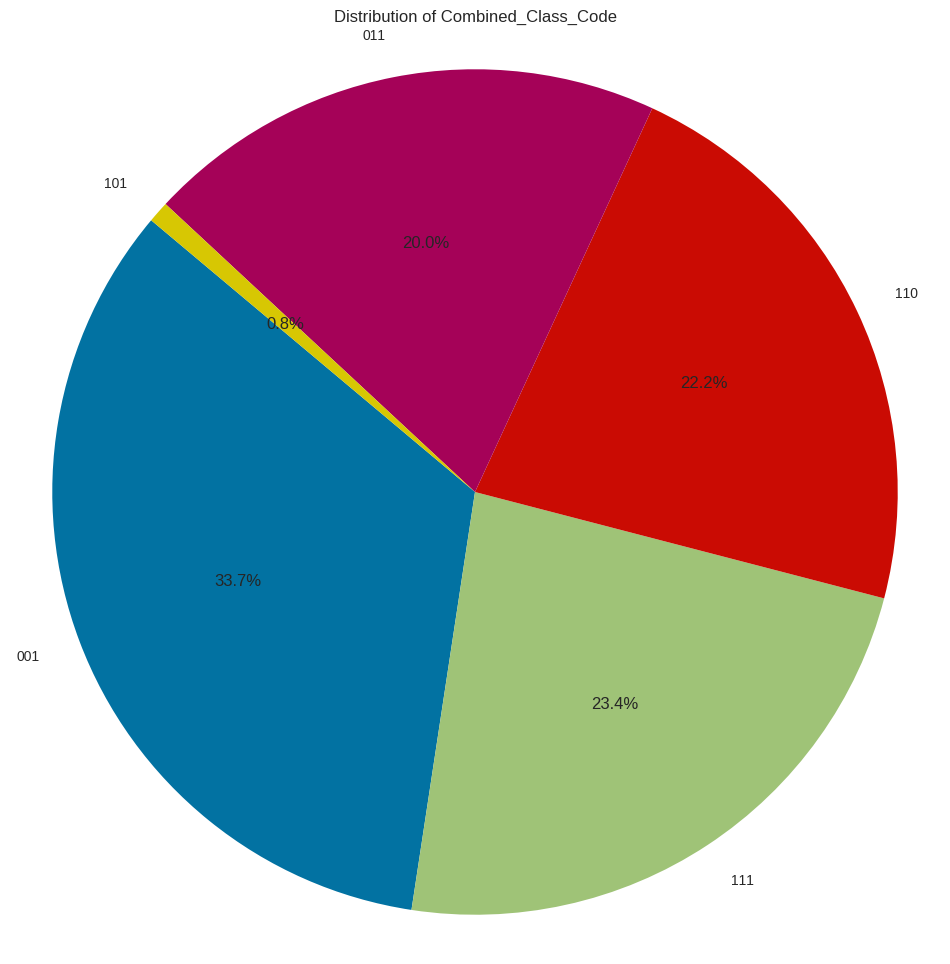

In [19]:
# Count occurrences of each unique code
counts = train_df["Combined_Class_Code"].value_counts()

# Plot pie chart
plt.figure(figsize=(12, 12))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Combined_Class_Code")
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()

In the pie chart above, you can see the Outcome Variables: The first digit indicates whether the participant requires physical support (1 = yes, 0 = no), and the same applies to the second digit for verbal support. The third digit reflects the participant’s gameplay ability (1 = yes, 0 = no).

110 – Not able to play  
111 – Needs verbal + physical support  
101 – Needs physical support only  
011 – Needs verbal support only  
001 – Independent play  

Due to the observed under-representation, the combination 101 has been excluded, resulting in the four outcome labels (110, 111, 011, 001).

In [20]:
train_df["Combined_Class_Code"].value_counts()

Combined_Class_Code
001    537
111    372
110    353
011    318
101     13
Name: count, dtype: int64

In [21]:
# Remove 
train_df = train_df[train_df['Combined_Class_Code'] != "101"]
train_df["Combined_Class_Code"].value_counts()

Combined_Class_Code
001    537
111    372
110    353
011    318
Name: count, dtype: int64

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1580 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Participant_ID       1580 non-null   int64  
 1   Game                 1580 non-null   object 
 2   Sex                  1580 non-null   object 
 3   Age                  1560 non-null   float64
 4   Previous experience  1580 non-null   object 
 5   Education level      1162 non-null   float64
 6   BMI                  956 non-null    float64
 7   Care level           1341 non-null   float64
 8   QMCI                 1562 non-null   float64
 9   4-m Gait Test        1580 non-null   int64  
 10  Chair Test           1580 non-null   int64  
 11  Mobility Aids        1580 non-null   int64  
 12  Balance Test         1580 non-null   float64
 13  Combined_Class_Code  1580 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 185.2+ KB


In [23]:
# Convert object columns to category
for col in train_df.select_dtypes(include='object').columns:
    train_df[col] = train_df[col].astype('category')

In [24]:
train_df.nunique().sort_values()

Sex                      2
Previous experience      2
Mobility Aids            2
Combined_Class_Code      4
4-m Gait Test            5
Chair Test               5
Balance Test             5
Education level          9
Care level              10
Game                    20
Age                     26
BMI                     55
QMCI                    75
Participant_ID         100
dtype: int64

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1580 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Participant_ID       1580 non-null   int64   
 1   Game                 1580 non-null   category
 2   Sex                  1580 non-null   category
 3   Age                  1560 non-null   float64 
 4   Previous experience  1580 non-null   category
 5   Education level      1162 non-null   float64 
 6   BMI                  956 non-null    float64 
 7   Care level           1341 non-null   float64 
 8   QMCI                 1562 non-null   float64 
 9   4-m Gait Test        1580 non-null   int64   
 10  Chair Test           1580 non-null   int64   
 11  Mobility Aids        1580 non-null   int64   
 12  Balance Test         1580 non-null   float64 
 13  Combined_Class_Code  1580 non-null   category
dtypes: category(4), float64(6), int64(4)
memory usage: 143.1 KB


In [26]:
# Store continuous and discrete features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Combined_Class_Code" ] # all columns without target

#category type features
categorical_features = [ "Game","Sex", "Previous experience", "Mobility Aids"]

#float type features
continuous_features = list(set(feature_list) - set(categorical_features))

#sanity check
assert feature_list.sort() == (categorical_features + continuous_features).sort()


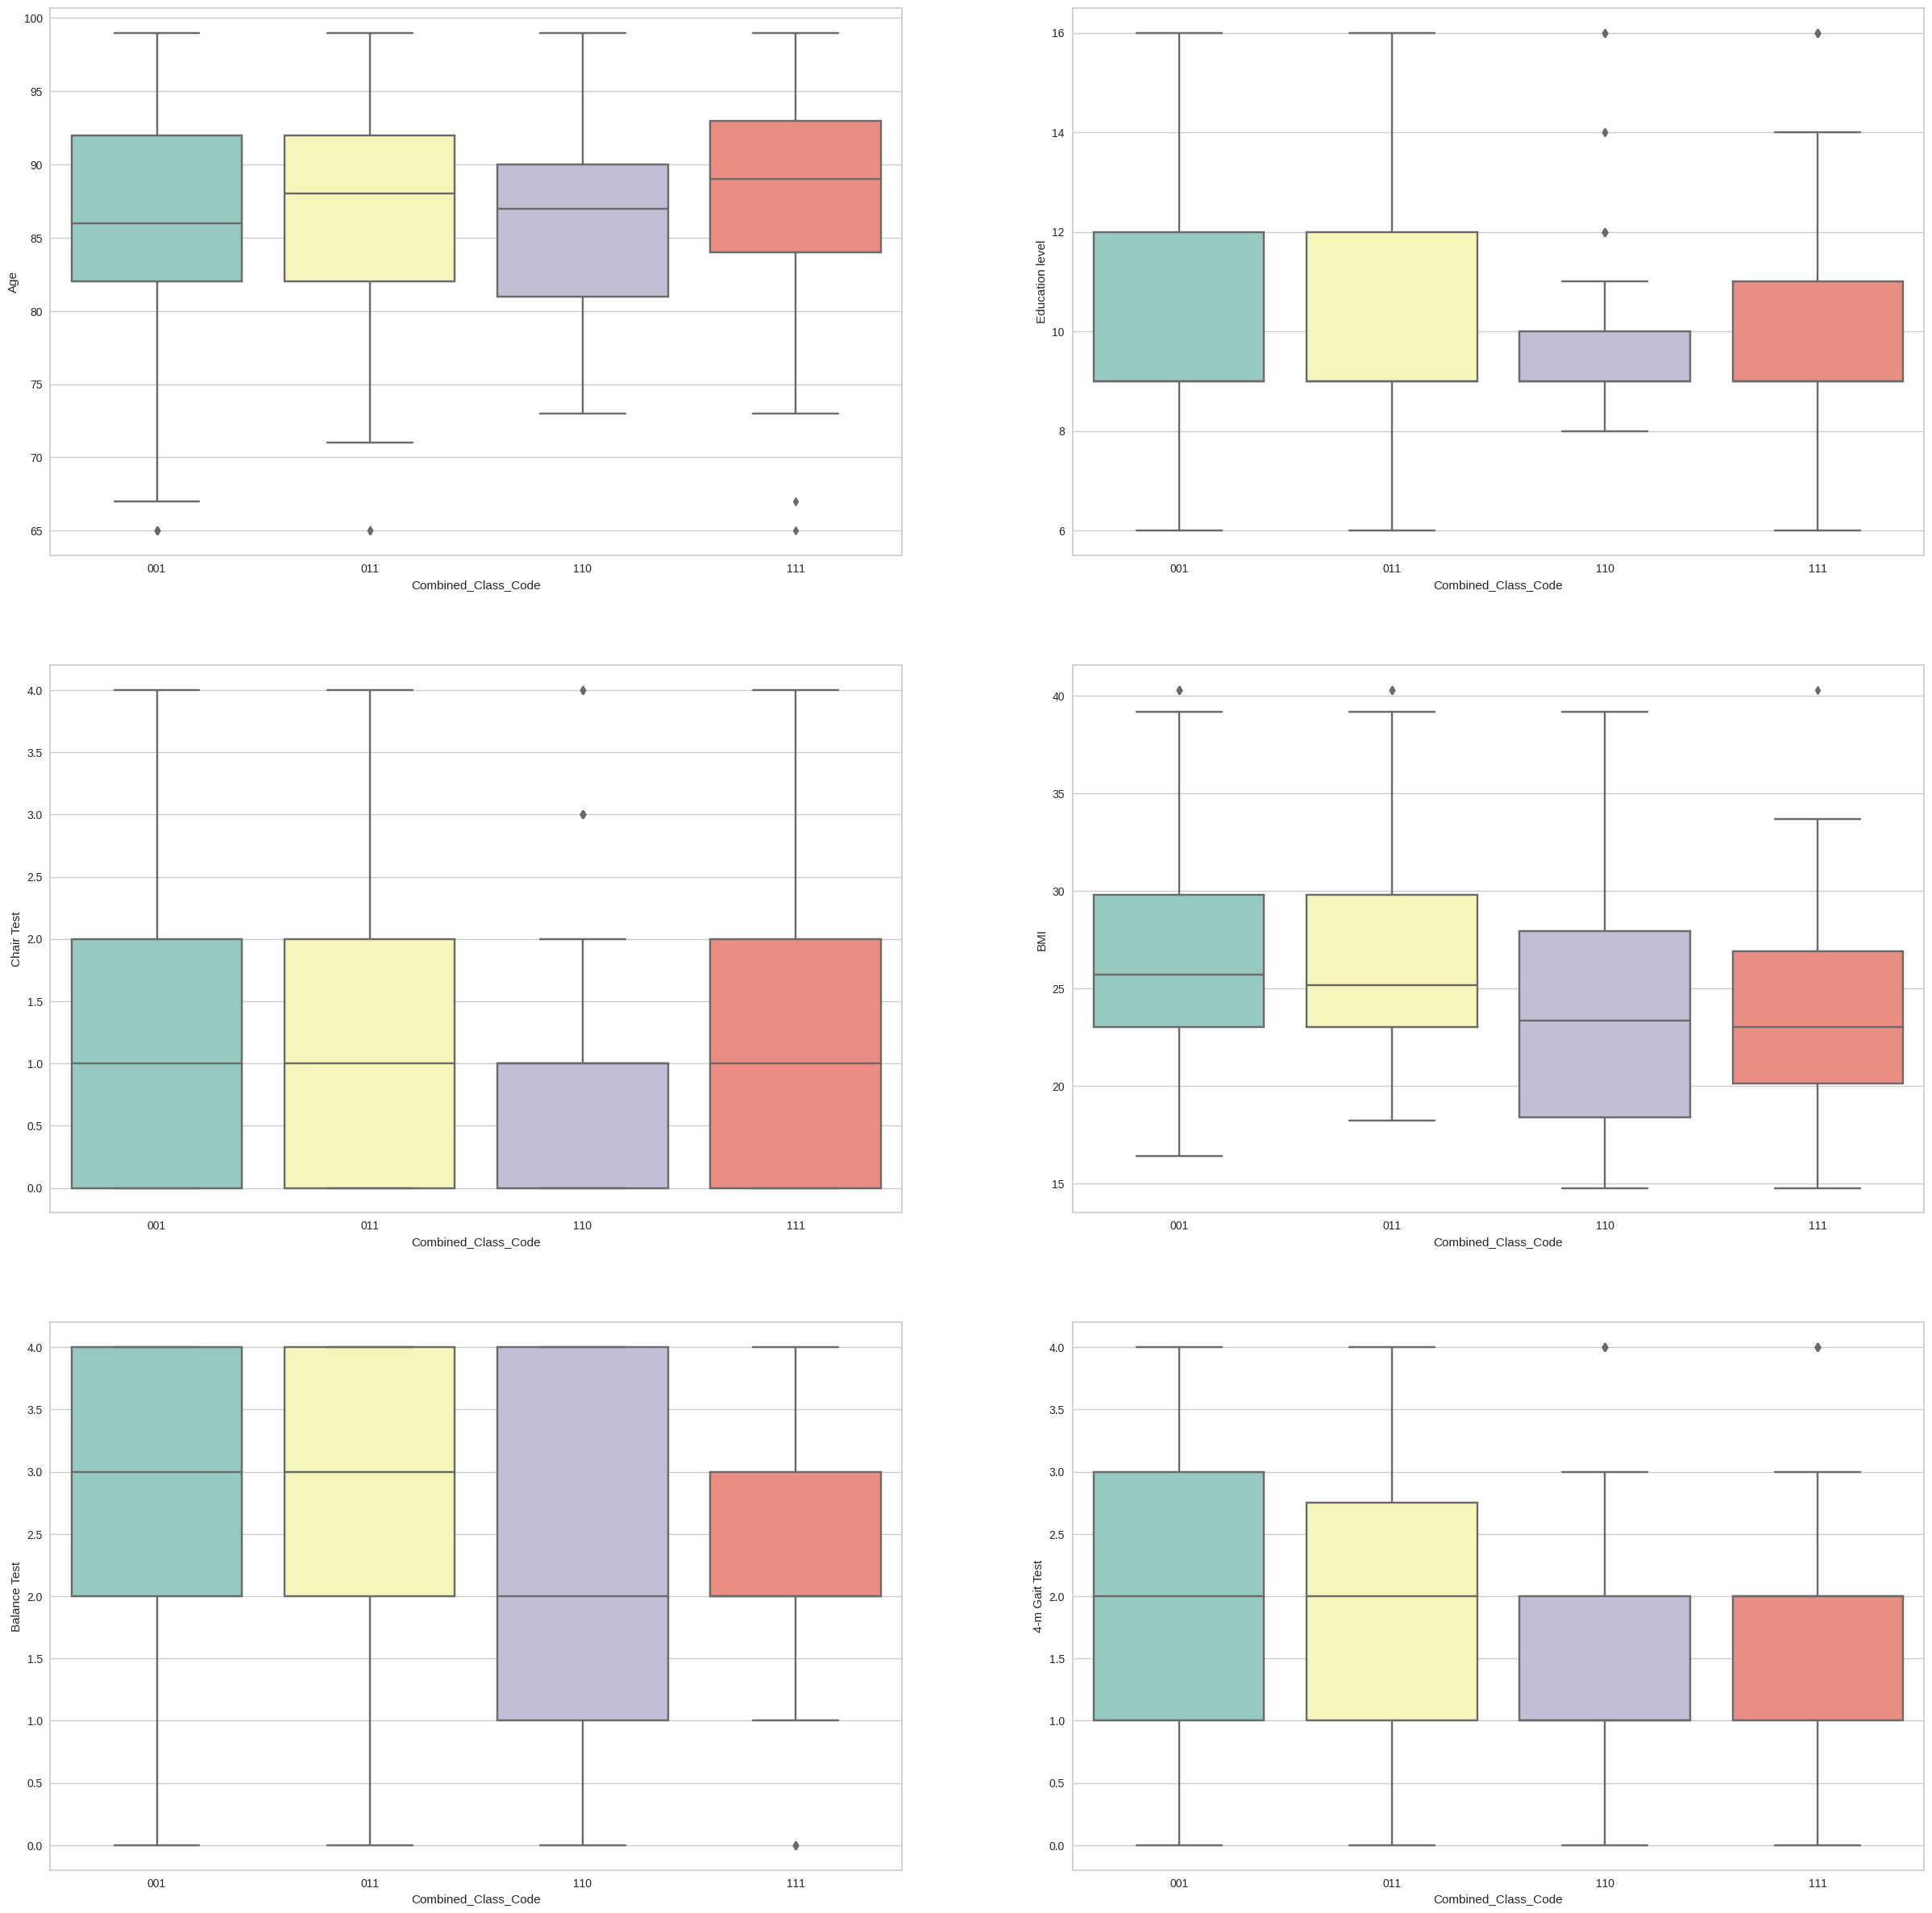

In [27]:
#Box-plots
fig, ax = plt.subplots(3, 2, figsize=(30, 30))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x="Combined_Class_Code", y=var, data=train_df, ax=subplot, palette='Set3')

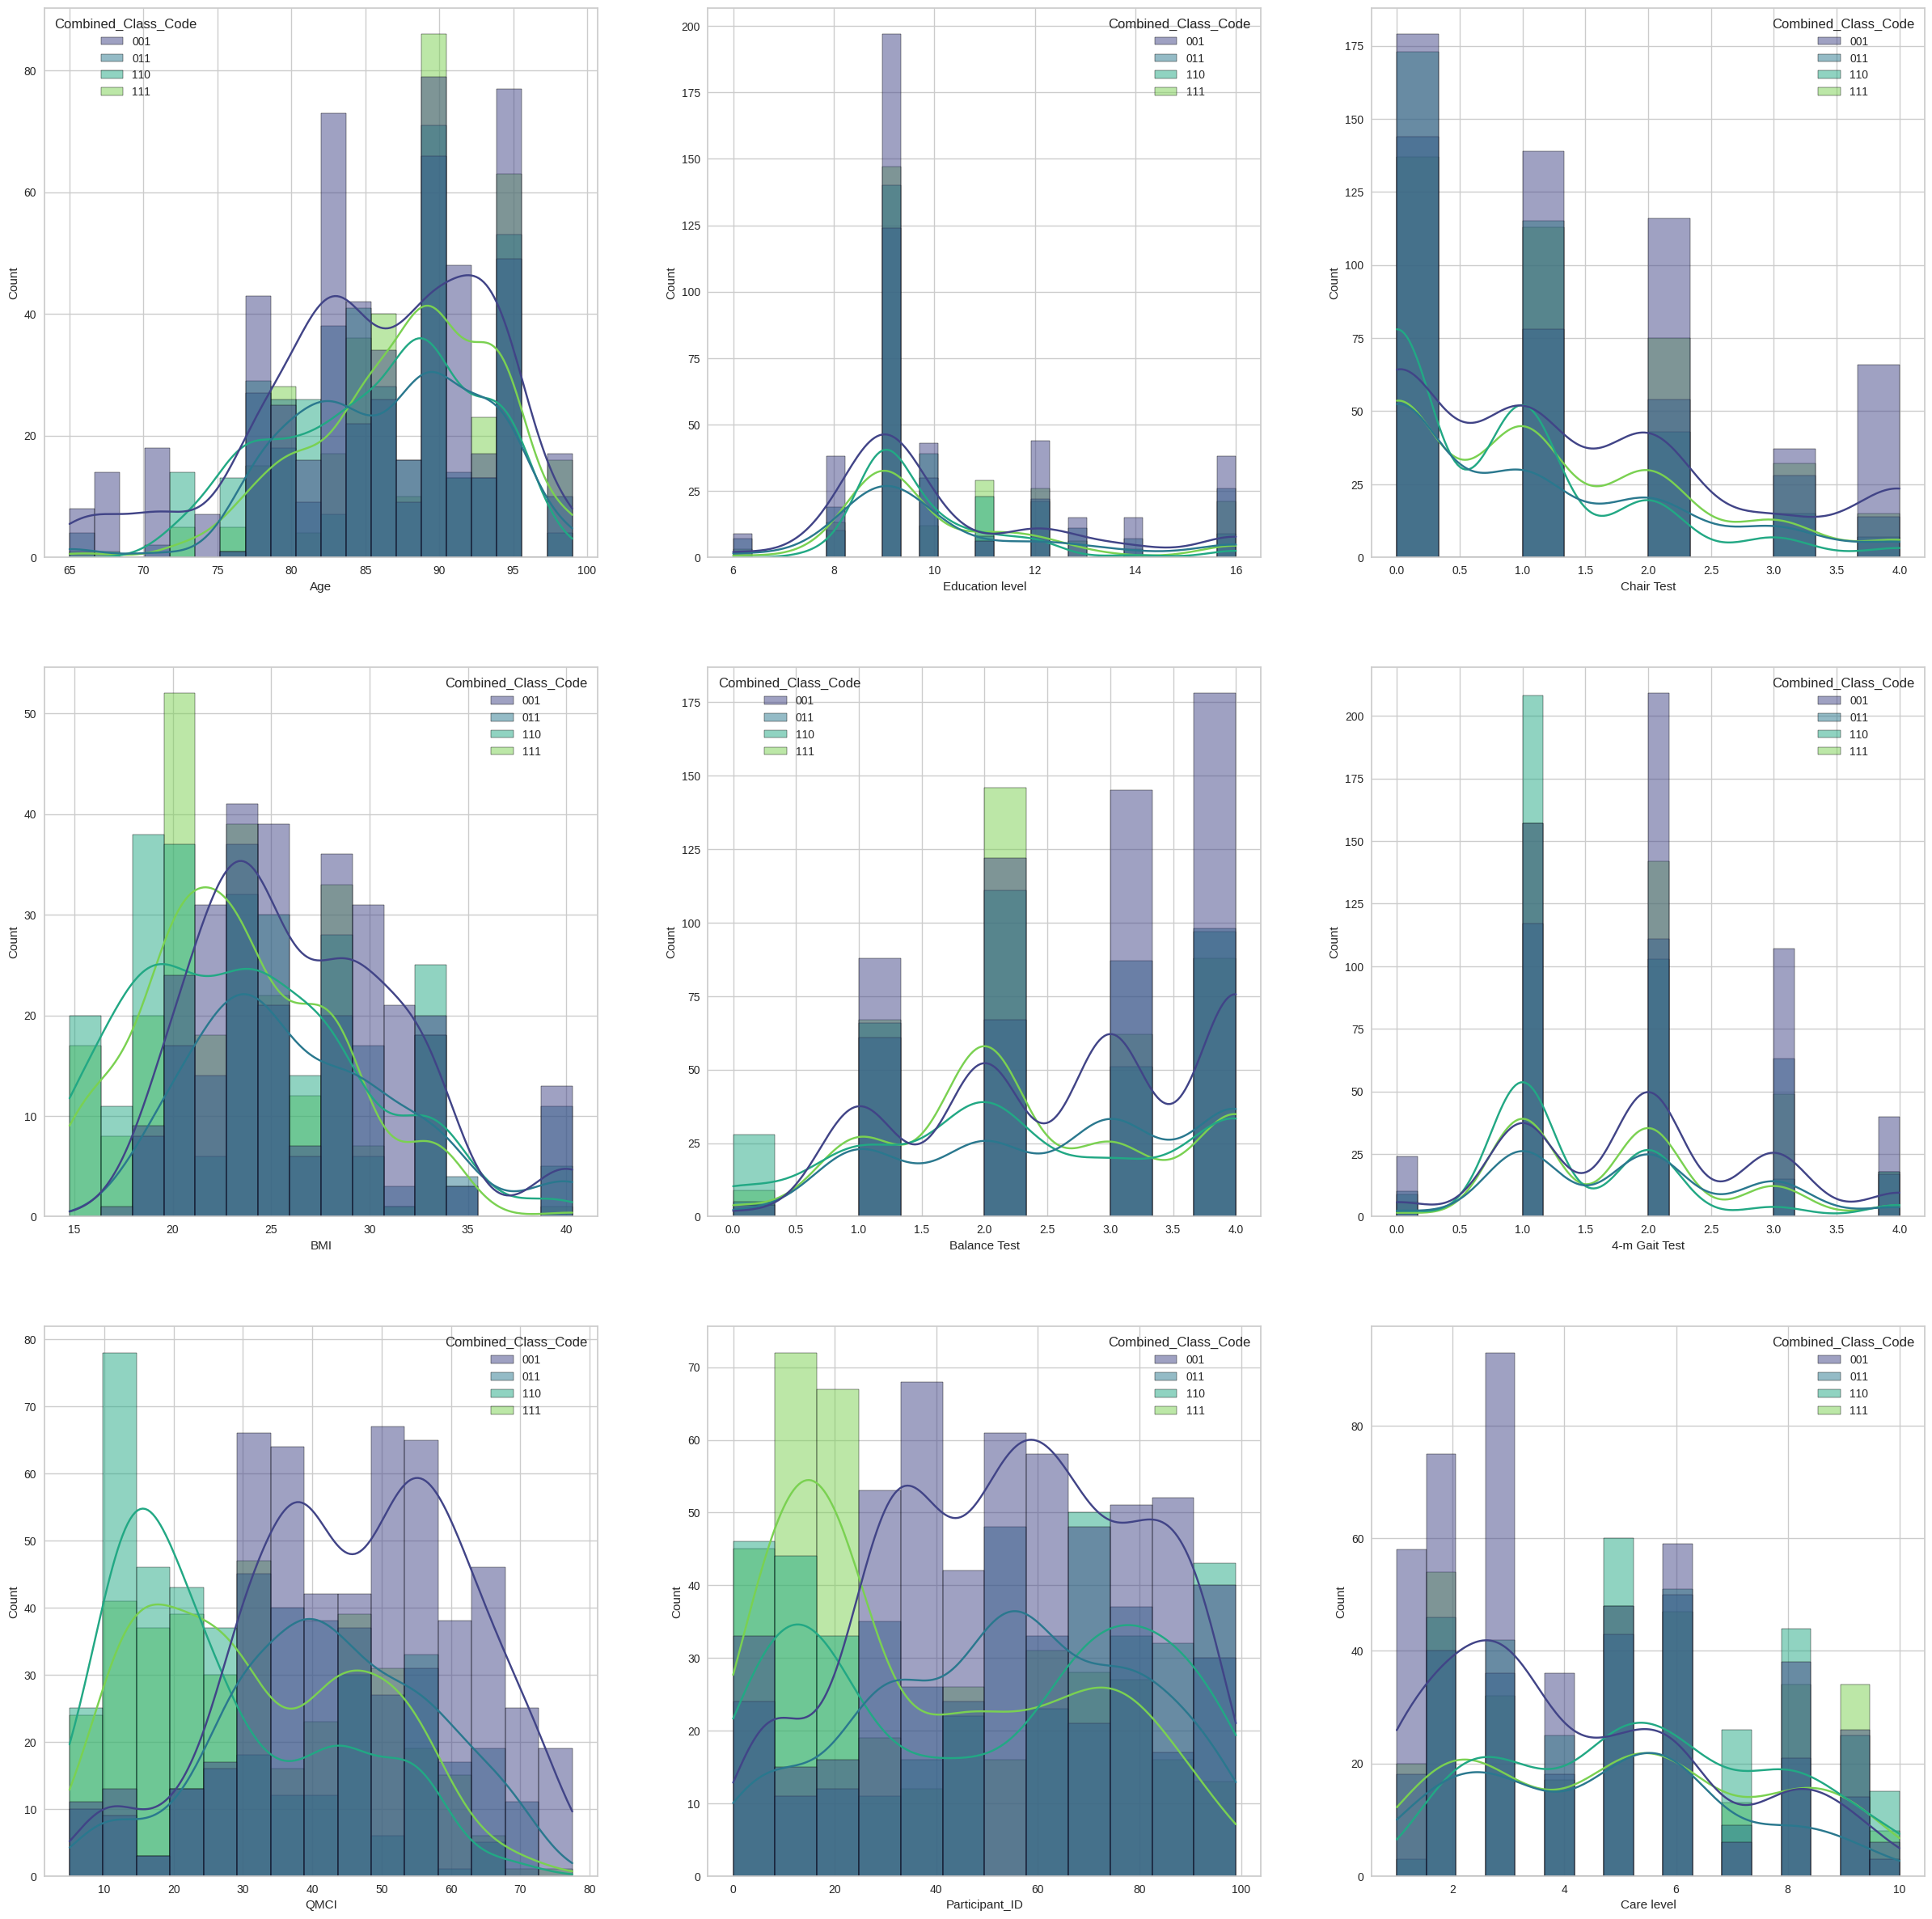

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.histplot(x=var,  data=train_df, ax=subplot, hue="Combined_Class_Code", kde=True ,  palette='viridis')

In [29]:
train_df

,Participant_ID,Game,Sex,Age,Previous experience,Education level,BMI,Care level,QMCI,4-m Gait Test,Chair Test,Mobility Aids,Balance Test,Combined_Class_Code
0,0,Rocket,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
1,0,Simple,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
2,0,Divided,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
3,0,Birds,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
4,0,Habitats,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,99,Hexagon,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
1993,99,Evolve,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
1994,99,Flexi,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,011
1995,99,Drops,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110


In [30]:
y = train_df["Combined_Class_Code"]

In [31]:
train_df[continuous_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1580 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              1560 non-null   float64
 1   Education level  1162 non-null   float64
 2   Chair Test       1580 non-null   int64  
 3   BMI              956 non-null    float64
 4   Balance Test     1580 non-null   float64
 5   4-m Gait Test    1580 non-null   int64  
 6   QMCI             1562 non-null   float64
 7   Participant_ID   1580 non-null   int64  
 8   Care level       1341 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 123.4 KB


In [32]:
# determine the mutual information for features
mutual_df = train_df[continuous_features]

mutual_info = mutual_info_classif(mutual_df.fillna(mutual_df.mean()), y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Participant_ID,0.396375
QMCI,0.368523
BMI,0.256350
Age,0.097051
Care level,0.051892
Education level,0.031529
Chair Test,0.024200
Balance Test,0.015199
4-m Gait Test,0.001868


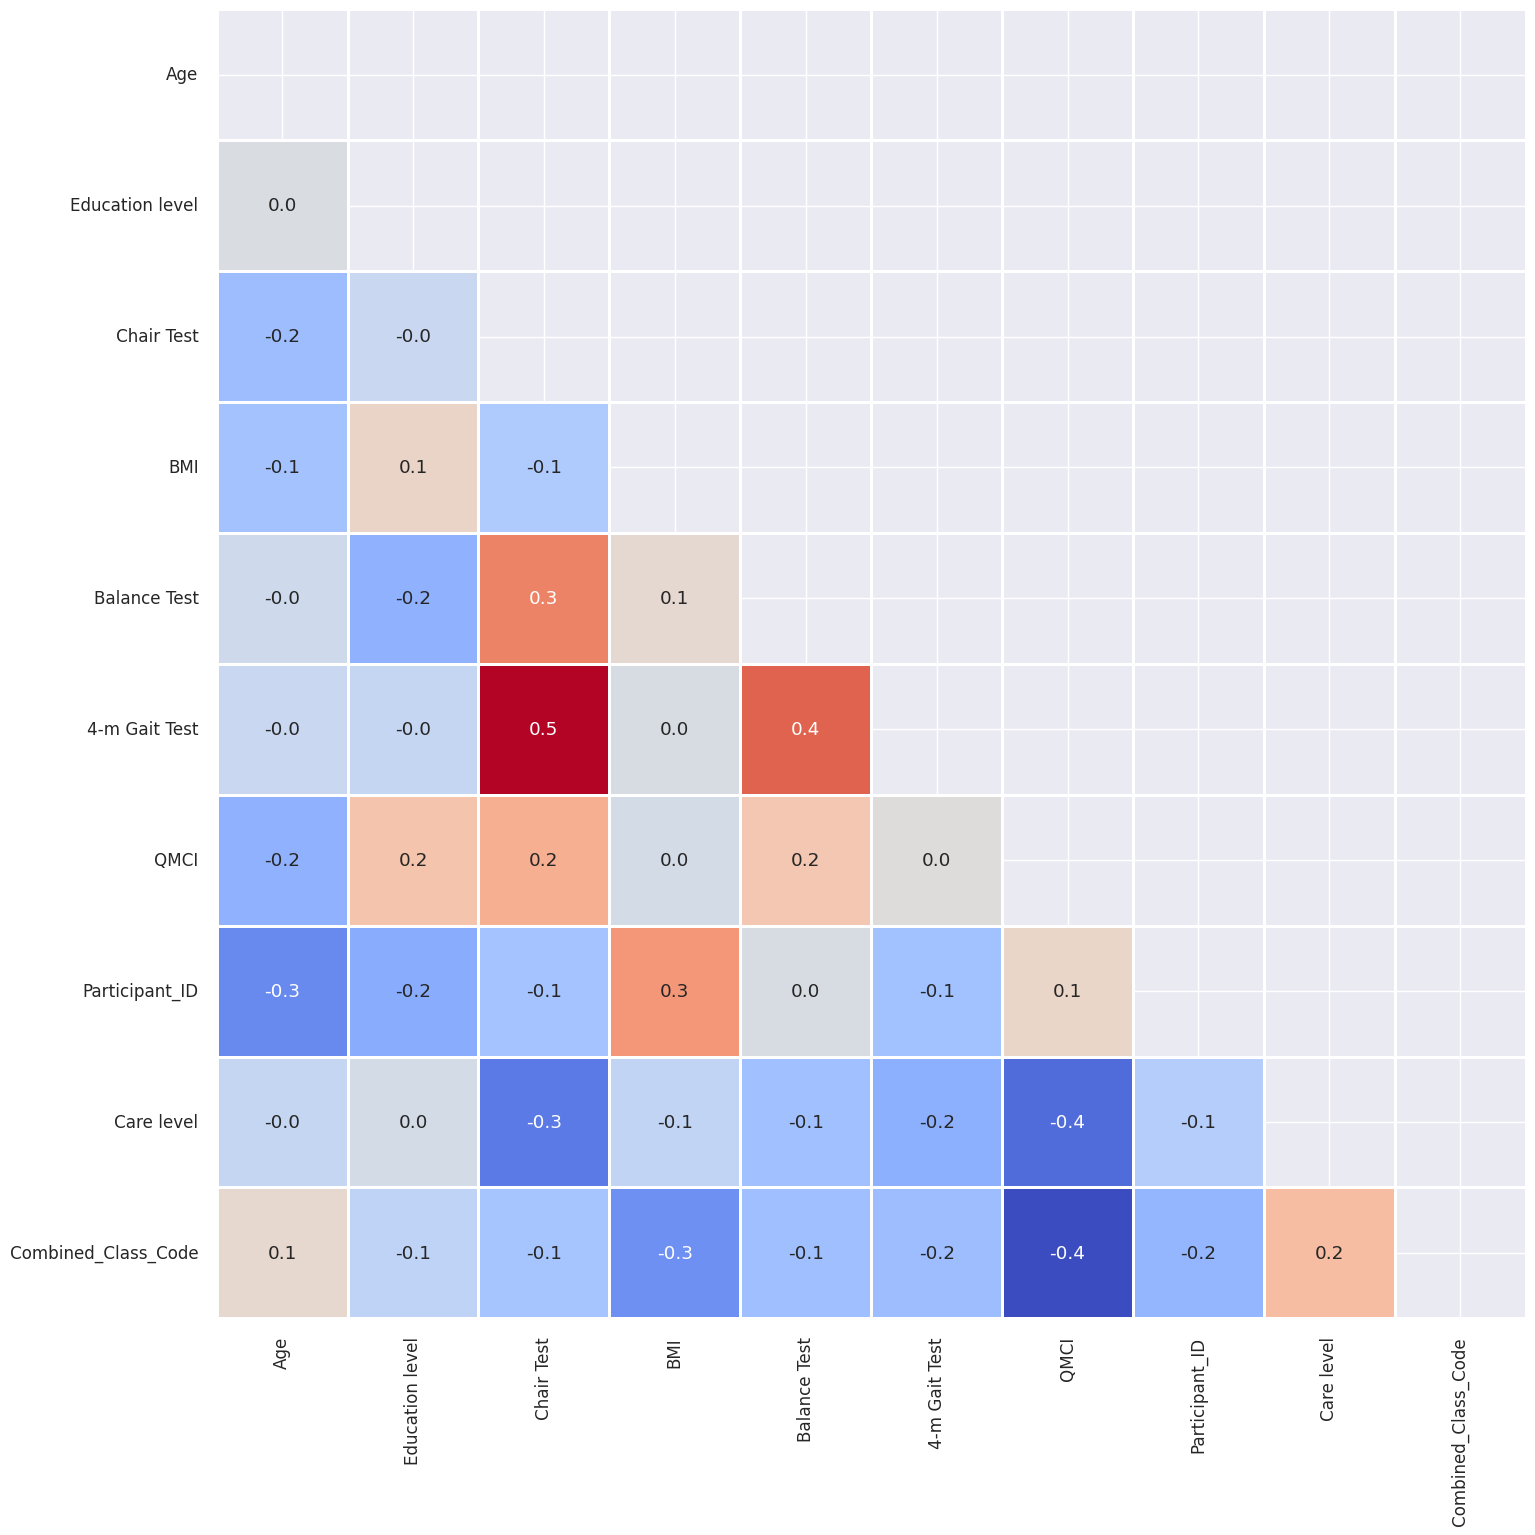

In [33]:
# Display correlations between numerical features
sns.set(font_scale=1.1)
correlation_train = train_df[continuous_features+["Combined_Class_Code"]].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

# Evaluation of Imputation and Scaling Method

Masked 1491 values
RMSE: 0.0772


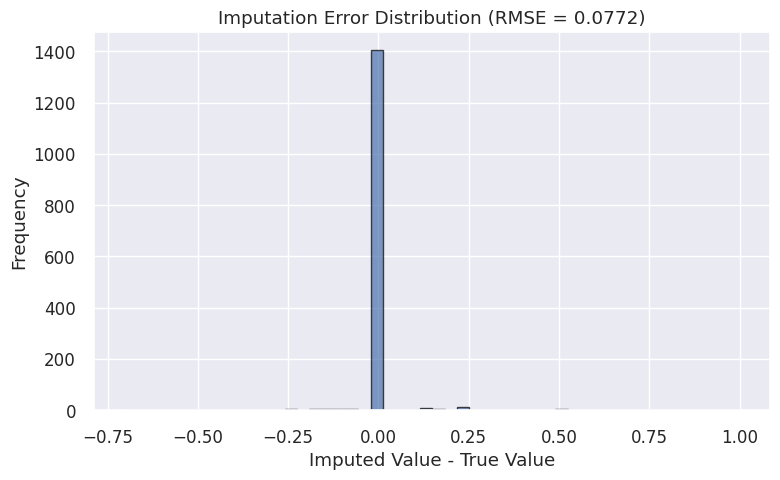

Masked 1491 values
RMSE: 0.0578


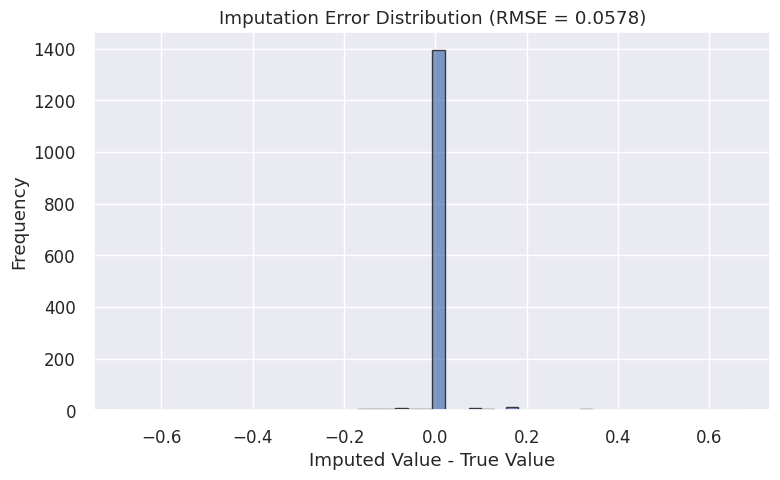

Masked 1491 values
RMSE: 0.0310


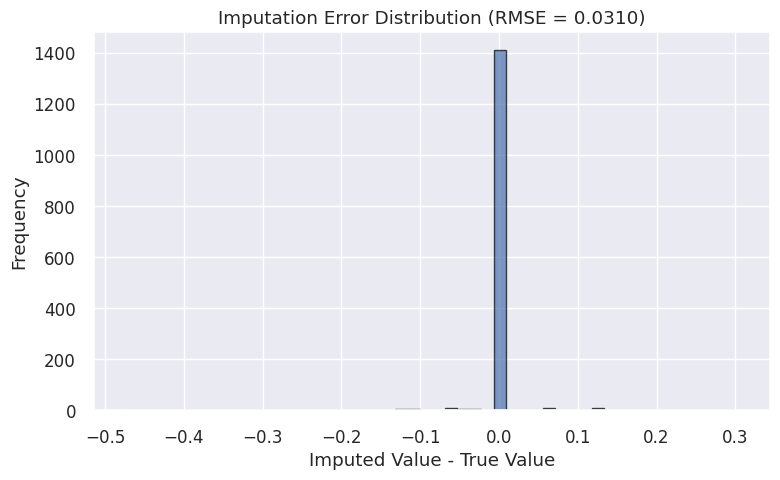

Masked 1491 values
RMSE: 0.0291


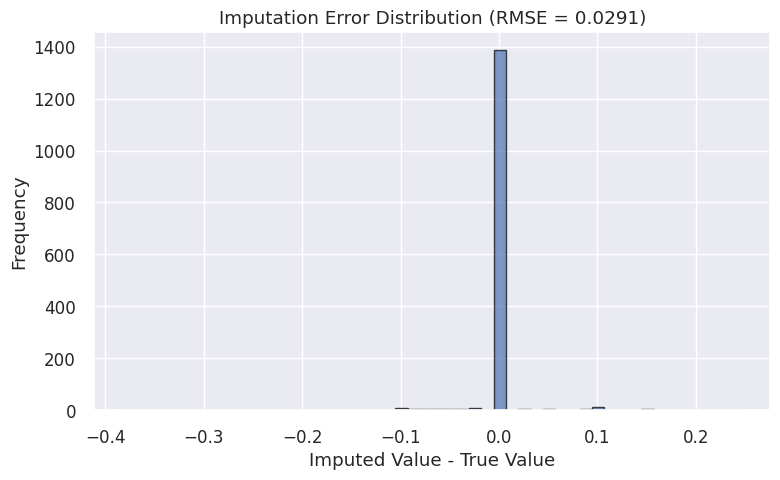

Masked 1491 values
RMSE: 0.0306


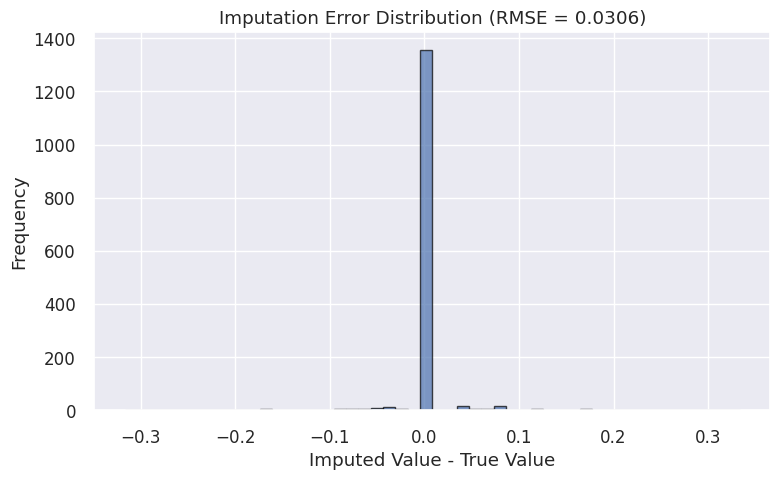

Masked 1491 values
RMSE: 1.0061


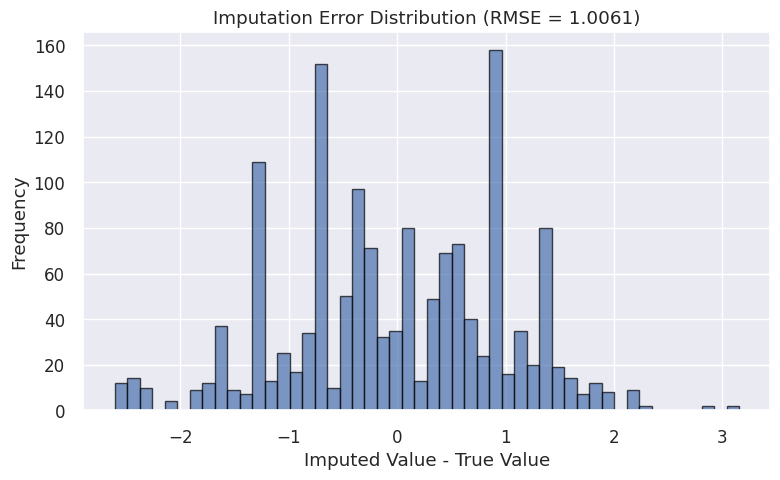

Masked 1491 values
RMSE: 0.1193


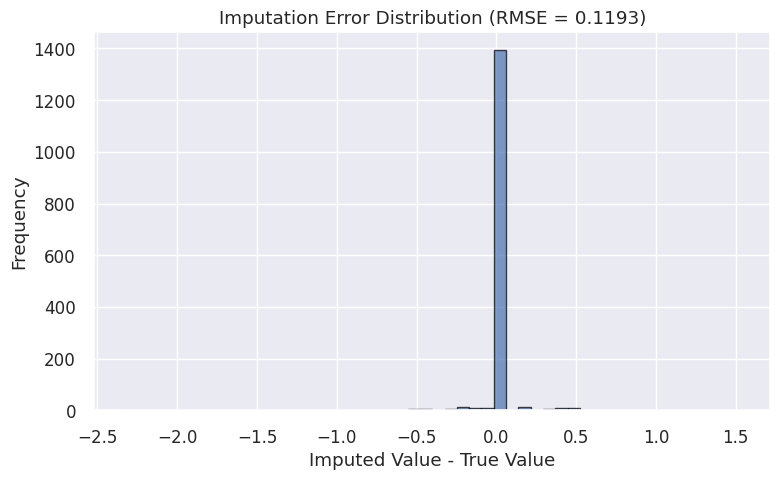

Masked 1491 values
RMSE: 0.7681


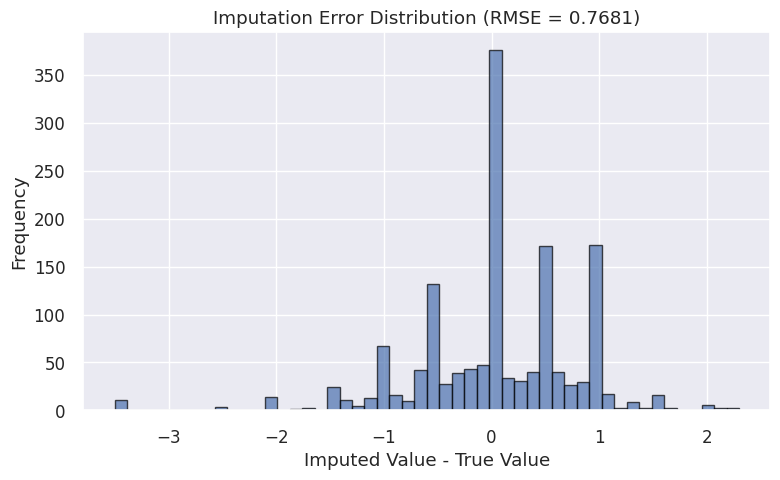

Masked 1491 values
RMSE: 0.1400


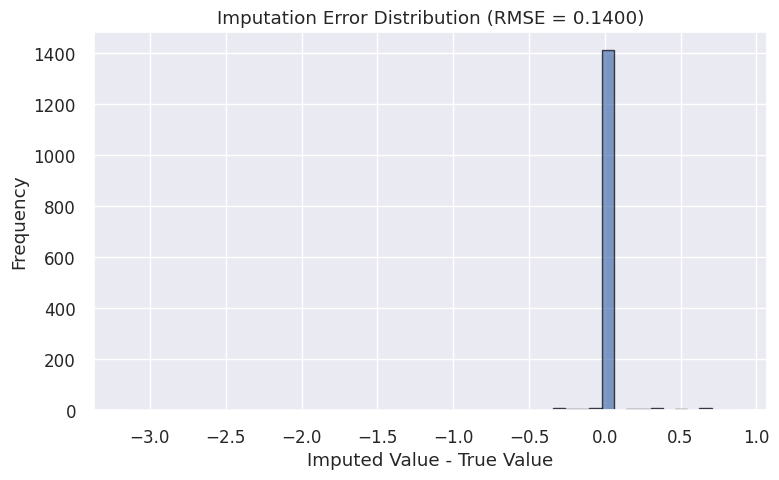

0.13995656344196175

In [34]:
def evaluate_imputer_with_plot(df, imputer, scaler, mask_fraction=0.1, random_state=random_state, plot=True, verbose=True):
    df = df.select_dtypes(include=[np.number])  
    np.random.seed(random_state)
    scaled_full = scaler.fit_transform(df)
    original_not_nan = ~np.isnan(scaled_full)
    random_mask = np.random.rand(*scaled_full.shape) < mask_fraction
    mask = random_mask & original_not_nan

    observed = scaled_full.copy()
    ground_truth = scaled_full.copy()
    observed[mask] = np.nan

    imputed = imputer.fit_transform(observed)

    errors = imputed[mask] - ground_truth[mask]
    rmse = np.sqrt(mean_squared_error(ground_truth[mask], imputed[mask]))

    if verbose:
        print(f"Masked {mask.sum()} values")
        print(f"RMSE: {rmse:.4f}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
        plt.title(f"Imputation Error Distribution (RMSE = {rmse:.4f})")
        plt.xlabel("Imputed Value - True Value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return rmse
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=2), MinMaxScaler())
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=3), MinMaxScaler())
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=4), MinMaxScaler()) 
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=5), MinMaxScaler()) 
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=6), MinMaxScaler())   
evaluate_imputer_with_plot(train_df, SimpleImputer(strategy='mean'), StandardScaler())  
evaluate_imputer_with_plot(train_df, KNNImputer(), StandardScaler())  
evaluate_imputer_with_plot(train_df, SimpleImputer(strategy='median'), RobustScaler())
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=3), RobustScaler())  


In [35]:
train_df.head()

,Participant_ID,Game,Sex,Age,Previous experience,Education level,BMI,Care level,QMCI,4-m Gait Test,Chair Test,Mobility Aids,Balance Test,Combined_Class_Code
0,0,Rocket,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
1,0,Simple,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
2,0,Divided,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
3,0,Birds,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
4,0,Habitats,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110


# Model Evaluation

In [36]:
#seperate target
y = train_df["Combined_Class_Code"]
train_df = train_df.drop(["Combined_Class_Code"], axis=1)

In [37]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
for train_idx, test_idx in sgkf.split(train_df, y, groups=train_df["Participant_ID"]):
    X_train = train_df.iloc[train_idx]
    X_test = train_df.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    break  # use only the first split


In [38]:
# Identify columns
continuous_features = X_train.select_dtypes(include=['number']).drop(columns="Participant_ID", errors="ignore").columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Numerical pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

#Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine both in a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, continuous_features),
    ('cat', categorical_pipeline, categorical_features)
])


In [39]:
overlap = set(X_train["Participant_ID"]) & set(X_test["Participant_ID"])
print("Overlap:", len(overlap))

Overlap: 0


Here you can see that all rows for each participant are either in the train or test part (prevents data leakage)


Running Optuna optimization for: LGBM
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[114]	valid_0's multi_logloss: 1.25951
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[114]	valid_0's multi_logloss: 1.33539
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[114]	valid_0's multi_logloss: 1.36915
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[114]	valid_0's multi_logloss: 1.32736
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[114]	valid_0's multi_logloss: 1.33418
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[921]	valid_0's multi_logloss: 0.916762
Training until validation scores don't improve for 50 rounds
Did not mee

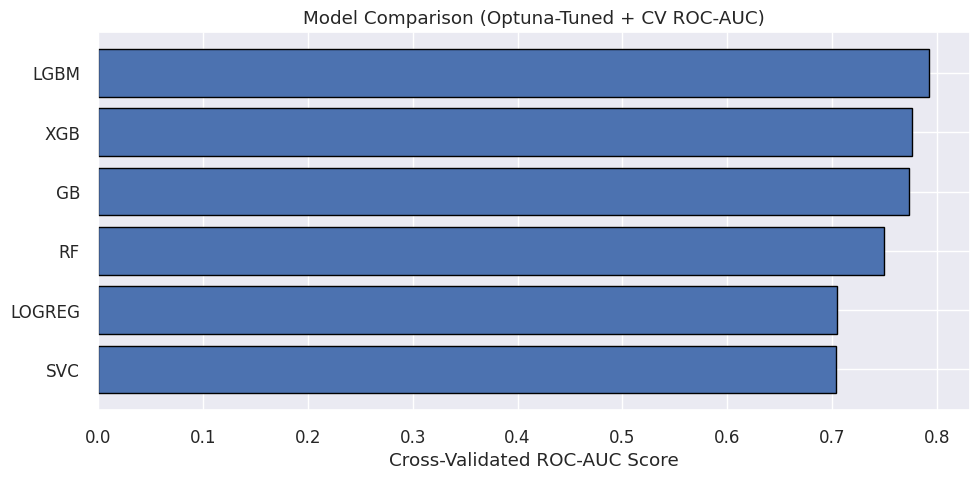

In [40]:
# Preprocessing Setup
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
groups = X_train["Participant_ID"]

# Identify features
numerical_cols = X_train.select_dtypes(include=['number']).drop(columns="Participant_ID").columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Objective Function
def objective(trial, model_type="lgbm"):
    n_estimators = trial.suggest_int("n_estimators", 30, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 12)

    if model_type == "xgb":
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            colsample_bytree=colsample_bytree,
            use_label_encoder=False,
            eval_metric="mlogloss",
            random_state=random_state
        )

    elif model_type == "lgbm":
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 20)
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        max_bin = trial.suggest_int("max_bin", 100, 350, step=10)
        feature_fraction = trial.suggest_float("feature_fraction", 0.1, 1.0)
        model = LGBMClassifier(
            verbosity=-1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_data_in_leaf=min_data_in_leaf,
            subsample=subsample,
            max_bin=max_bin,
            feature_fraction=feature_fraction,
            random_state=random_state
        )

    elif model_type == "rf":
        max_features = trial.suggest_float("max_features", 0.1, 1.0)
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=random_state
        )

    elif model_type == "gb":
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=random_state
        )

    elif model_type == "svc":
        C = trial.suggest_float("C", 0.01, 10.0, log=True)
        model = SVC(C=C, kernel="rbf", probability=True, random_state=random_state)

    elif model_type == "logreg":
        C = trial.suggest_float("C", 0.01, 10.0, log=True)
        model = LogisticRegression(C=C, max_iter=1000, solver="lbfgs", multi_class="ovr", random_state=random_state)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
    oof_preds, oof_targets, oof_probas = [], [], []

    for train_idx, val_idx in sgkf.split(X_train, y_train_encoded, groups=groups):
        X_tr = X_train.iloc[train_idx].drop(columns=["Participant_ID"])
        X_val = X_train.iloc[val_idx].drop(columns=["Participant_ID"])
        y_tr = y_train_encoded[train_idx]
        y_val = y_train_encoded[val_idx]

        X_tr_proc = preprocessor.fit_transform(X_tr)
        X_val_proc = preprocessor.transform(X_val)


        if model_type == "lgbm":
            model.fit(
                X_tr_proc, y_tr,
                eval_set=[(X_val_proc, y_val)],
                eval_metric="multi_logloss",
                callbacks=[early_stopping(50)],
            )
        else:
            model.fit(X_tr_proc, y_tr)

        y_pred = model.predict(X_val_proc)
        y_proba = model.predict_proba(X_val_proc)

        oof_preds.extend(y_pred)
        oof_probas.extend(y_proba)
        oof_targets.extend(y_val)

    cv_auc = roc_auc_score(oof_targets, oof_probas, multi_class='ovr')
    return cv_auc

# Model Optimization
models_to_compare = ["lgbm", "xgb", "rf", "gb", "svc", "logreg"]
results = {}

for model_type in models_to_compare:
    print(f"\nRunning Optuna optimization for: {model_type.upper()}")
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=57))
    study.optimize(lambda trial: objective(trial, model_type), n_trials=100)

    print(f"Best AUC for {model_type.upper()}: {study.best_value:.4f}")
    print(f"Best Params for {model_type.upper()}: {study.best_params}")
    results[model_type] = {
        "CV ROC-AUC": study.best_value,
        "params": study.best_params
    }

# Leaderboard
leaderboard_df = pd.DataFrame([
    {"Model": model.upper(), "CV ROC-AUC": metrics["CV ROC-AUC"], **metrics}
    for model, metrics in results.items()
]).sort_values(by="CV ROC-AUC", ascending=False).reset_index(drop=True)

print("\nModel Leaderboard (Cross-Validated):")
print(leaderboard_df[["Model", "CV ROC-AUC"]])

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.barh(leaderboard_df["Model"], leaderboard_df["CV ROC-AUC"], edgecolor='black')
plt.xlabel("Cross-Validated ROC-AUC Score")
plt.title("Model Comparison (Optuna-Tuned + CV ROC-AUC)")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [41]:
# Extract only Optuna-tuned models
best_params_all_models = {
    model_name: result["params"]
    for model_name, result in results.items()
    if isinstance(result, dict) and "params" in result
}

# Model classes and valid params per model
model_classes = {
    "lgbm": LGBMClassifier,
    "xgb": XGBClassifier,
    "rf": RandomForestClassifier,
    "gb": GradientBoostingClassifier,
    "svc": SVC,
    "logreg": LogisticRegression
}

model_param_filters = {
    "lgbm": {"n_estimators", "max_depth", "learning_rate", "min_data_in_leaf", "subsample", "max_bin", "feature_fraction"},
    "xgb": {"n_estimators", "max_depth", "learning_rate", "colsample_bytree"},
    "rf": {"n_estimators", "max_depth", "max_features"},
    "gb": {"n_estimators", "max_depth", "learning_rate", "subsample"},
    "svc": {"C"},
    "logreg": {"C"},
}

# Evaluation Loop for Fixed Models
fixed_results = {}
for model_name, params in best_params_all_models.items():
    print(f"\nEvaluating {model_name.upper()} with fixed Optuna parameters...")

    ModelClass = model_classes[model_name]
    allowed_keys = model_param_filters[model_name]
    filtered_params = {k: v for k, v in params.items() if k in allowed_keys}

    if model_name == "svc":
        filtered_params["probability"] = True

    model = ModelClass(**filtered_params, random_state=random_state)

    val_aucs, train_aucs = [], []
    oof_preds, oof_targets, oof_probas = [], [], []
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

    for train_idx, val_idx in sgkf.split(X_train, y_train_encoded, groups=groups):
        X_tr = X_train.iloc[train_idx].drop(columns=["Participant_ID"])
        X_val = X_train.iloc[val_idx].drop(columns=["Participant_ID"])
        y_tr = y_train_encoded[train_idx]
        y_val = y_train_encoded[val_idx]

        X_tr_proc = preprocessor.fit_transform(X_tr)
        X_val_proc = preprocessor.transform(X_val)
        

        if model_name == "lgbm":
            model.fit(
                X_tr_proc, y_tr,
                eval_set=[(X_val_proc, y_val)],
                eval_metric="multi_logloss",
                callbacks=[early_stopping(50)],
            )
        elif model_name == "xgb":
            model.set_params(use_label_encoder=False, eval_metric="mlogloss")
            model.fit(X_tr_proc, y_tr)
        else:
            model.fit(X_tr_proc, y_tr)

        y_pred = model.predict(X_val_proc)
        y_proba = model.predict_proba(X_val_proc)
        y_proba_train = model.predict_proba(X_tr_proc)

        oof_preds.extend(y_pred)
        oof_probas.extend(y_proba)
        oof_targets.extend(y_val)

        val_auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
        train_auc = roc_auc_score(y_tr, y_proba_train, multi_class='ovr')
        val_aucs.append(val_auc)
        train_aucs.append(train_auc)

    fixed_results[model_name ] = {
        "CV ROC-AUC": round(roc_auc_score(oof_targets, oof_probas, multi_class='ovr'), 4),
        "CV Accuracy": round(accuracy_score(oof_targets, oof_preds), 4),
        "CV Precision": round(precision_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "CV Recall": round(recall_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "CV F1": round(f1_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
    }

# Fixed Models Leaderboard
fixed_leaderboard_df = pd.DataFrame([
    {"Model": model.upper(), **metrics}
    for model, metrics in fixed_results.items()
]).sort_values(by="CV ROC-AUC", ascending=False).reset_index(drop=True)

print("\n Optuna Models Leaderboard:")
print(fixed_leaderboard_df)



Evaluating LGBM with fixed Optuna parameters...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[705]	valid_0's multi_logloss: 0.833983
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[579]	valid_0's multi_logloss: 1.05836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[550]	valid_0's multi_logloss: 1.14562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[757]	valid_0's multi_logloss: 0.954656
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	valid_0's multi_logloss: 1.16818

Evaluating XGB with fixed Optuna parameters...

Evaluating RF with fixed Optuna parameters...

Evaluating GB with fixed Optuna parameters...

Evaluating SVC with fixed Optuna parameters...

Evaluating LOGREG with fixed Optuna parameters...

 Optuna Models Leaderboard:
    

# Best Model CV reproduction

In [42]:
# Retrieve Best Params from the Initial Multi-Model Tuning
best_params = results['lgbm']['params']
print(f"\nUsing Best Parameters from Multi-Model Tuning: {best_params}")

continuous_features = X_train.select_dtypes(include=['number']).drop(columns="Participant_ID", errors="ignore").columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, continuous_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Setup Data for Verification
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
groups = X_train["Participant_ID"]

print("\nVerifying reproducibility with Cross-Validation...")

verification_model = LGBMClassifier(**best_params, random_state=random_state)
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
oof_probas, oof_targets, oof_preds = [], [], []

for train_idx, val_idx in sgkf.split(X_train, y_train_encoded, groups=groups):
    # Split data
    X_tr = X_train.iloc[train_idx].drop(columns=["Participant_ID"])
    X_val = X_train.iloc[val_idx].drop(columns=["Participant_ID"])
    y_tr = y_train_encoded[train_idx]
    y_val = y_train_encoded[val_idx]

    # Fit preprocessor INSIDE the loop
    X_tr_proc = preprocessor.fit_transform(X_tr)
    X_val_proc = preprocessor.transform(X_val)

    # Fit with early stopping
    verification_model.fit(
        X_tr_proc, y_tr,
        eval_set=[(X_val_proc, y_val)],
        eval_metric="multi_logloss",
        callbacks=[early_stopping(50)]
    )

    y_pred = verification_model.predict(X_val_proc)
    y_proba = verification_model.predict_proba(X_val_proc)
    
    oof_preds.extend(y_pred)
    oof_probas.extend(y_proba)
    oof_targets.extend(y_val)

cv_score = roc_auc_score(oof_targets, oof_probas, multi_class='ovr')
print(f"\nReproduced CV ROC-AUC: {cv_score:.4f}")


Using Best Parameters from Multi-Model Tuning: {'n_estimators': 910, 'max_depth': 11, 'learning_rate': 0.0059370020429546635, 'min_data_in_leaf': 20, 'subsample': 0.8528450828049943, 'max_bin': 150, 'feature_fraction': 0.6136991955025036}

Verifying reproducibility with Cross-Validation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[705]	valid_0's multi_logloss: 0.833983
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[579]	valid_0's multi_logloss: 1.05836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[550]	valid_0's multi_logloss: 1.14562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[757]	valid_0's multi_logloss: 0.954656
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	valid_0's multi_logloss: 1.16818

Reproduced CV ROC-AUC: 0.7922


# To save the model, preprocessor and label encoder

In [43]:
# Final training using best params
final_model = LGBMClassifier(**best_params, random_state=random_state)

X_train_clean = X_train.drop(columns=["Participant_ID"], errors="ignore")
X_train_proc = preprocessor.fit_transform(X_train_clean)

final_model.fit(X_train_proc, y_train_encoded)

# Save model + preprocessor + label encoder
import joblib
joblib.dump(final_model, "lgbm.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [44]:
X_train = X_train.drop(columns=["Participant_ID"], errors="ignore")
X_test = X_test.drop(columns=["Participant_ID"], errors="ignore")

In [45]:
best_params = results['lgbm']['params']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Use this for training
y_test_encoded = label_encoder.transform(y_test)

lgbm_classifier = LGBMClassifier(**best_params, random_state=random_state, verbose=-1)

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ("lgbm", lgbm_classifier)
])

lgbm_pipeline.fit(X_train, y_train_encoded)

y_test_proba = lgbm_pipeline.predict_proba(X_test)
y_test_pred = lgbm_pipeline.predict(X_test)

test_auc = roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr')
print(f"Test ROC-AUC: {test_auc:.4f}")

Test ROC-AUC: 0.7709


In [46]:
# Combine predictions and true labels with Game info for analysis
test_results = X_test.copy()
test_results['y_true'] = y_test
test_results['Game'] = X_test['Game']  
test_results['y_pred_proba'] = list(y_test_proba) 

# Convert to DataFrame format with class probabilities as separate columns
proba_df = pd.DataFrame(y_test_proba, columns=[f'class_{i}' for i in range(y_test_proba.shape[1])])
test_results = test_results.reset_index(drop=True).join(proba_df)

# Group by Game and compute ROC-AUC per group
game_scores = []

for game, group in test_results.groupby('Game'):
    try:
        y_true = group['y_true']
        y_proba = group[[f'class_{i}' for i in range(y_test_proba.shape[1])]]
        score = roc_auc_score(y_true, y_proba, multi_class='ovr')
        game_scores.append({'Game': game, 'ROC_AUC': score})
    except ValueError:
        # Not enough classes present in this group to compute AUC
        game_scores.append({'Game': game, 'ROC_AUC': None})

# Convert to DataFrame for easy viewing
game_auc_df = pd.DataFrame(game_scores).sort_values(by='ROC_AUC', ascending=False)
game_auc_df


,Game,ROC_AUC
0,Arrows,0.853519
7,Flexi,0.805288
11,Lumina,0.804138
3,Divided,0.787931
1,Birds,0.745244
16,Simple,0.742710
10,Ladybug,0.729433
8,Habitats,0.724858
2,Cloudy,0.668466
9,Hexagon,0.660847


In [47]:
# Combine y_test and Game column
y_test_df = X_test[['Game']].copy()
y_test_df['y_true'] = y_test

# Group by Game and class, then count the samples
class_counts_per_game = y_test_df.groupby(['Game', 'y_true']).size().unstack(fill_value=0)
class_counts_per_game

y_true,001,011,110,111
Game,,,,
Arrows,3,6,4,2
Birds,7,5,2,4
Cloudy,4,5,1,6
Divided,4,2,7,2
Drops,2,3,7,2
Evolve,5,2,1,8
Flaneur,16,1,0,3
Flexi,9,2,4,2
Habitats,4,6,4,3


As you can see there are outcome labels with 0 in the test. That's why there were some NA when evaluating each game seperately.

In [48]:
# Combine predictions and true labels with Game info for analysis
test_results = X_test.copy()
test_results['y_true'] = y_test
test_results['Game'] = X_test['Game']  # Ensure Game column is present
test_results['y_pred_proba'] = list(y_test_proba)  # Optional, not strictly needed here

# Convert class probabilities into separate columns
proba_df = pd.DataFrame(y_test_proba, columns=[f'class_{i}' for i in range(y_test_proba.shape[1])])
test_results = test_results.reset_index(drop=True).join(proba_df)

# Compute ROC-AUC per Game
game_scores = []

for game, group in test_results.groupby('Game'):
    y_true = group['y_true']
    class_count = y_true.nunique()

    if class_count >= 2:
        y_proba = group[[f'class_{i}' for i in range(y_test_proba.shape[1])]]
        try:
            score = roc_auc_score(y_true, y_proba, multi_class='ovr')
        except ValueError:
            score = None 
    else:
        score = None  # Only one class present

    game_scores.append({
        'Game': game,
        'ROC_AUC': score,
        'Class_Count': class_count
    })

# Convert to DataFrame for analysis
game_auc_df = pd.DataFrame(game_scores).sort_values(by='ROC_AUC', ascending=False)
game_auc_df

,Game,ROC_AUC,Class_Count
0,Arrows,0.853519,4
7,Flexi,0.805288,4
11,Lumina,0.804138,4
3,Divided,0.787931,4
1,Birds,0.745244,4
16,Simple,0.742710,4
10,Ladybug,0.729433,4
8,Habitats,0.724858,4
2,Cloudy,0.668466,4
9,Hexagon,0.660847,4


In [49]:
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Get predicted class labels
y_test_pred = lgbm_pipeline.predict(X_test)

# Combine predictions, true labels, and Game info
test_results = X_test.copy()
test_results['y_true'] = y_test_encoded
test_results['y_pred'] = y_test_pred
test_results['Game'] = X_test['Game']  

# Group by Game and compute accuracy per group
game_scores = []

for game, group in test_results.groupby('Game'):
    y_true = group['y_true']
    y_pred = group['y_pred']
    score = accuracy_score(y_true, y_pred)
    game_scores.append({'Game': game, 'Accuracy': score})

# Convert to DataFrame for viewing
game_accuracy_df = pd.DataFrame(game_scores).sort_values(by='Accuracy', ascending=False)
game_accuracy_df

,Game,Accuracy
6,Flaneur,0.900000
12,React,0.785714
16,Simple,0.684211
13,Rocket,0.650000
7,Flexi,0.647059
9,Hexagon,0.583333
1,Birds,0.555556
10,Ladybug,0.550000
15,Simon,0.533333
0,Arrows,0.533333


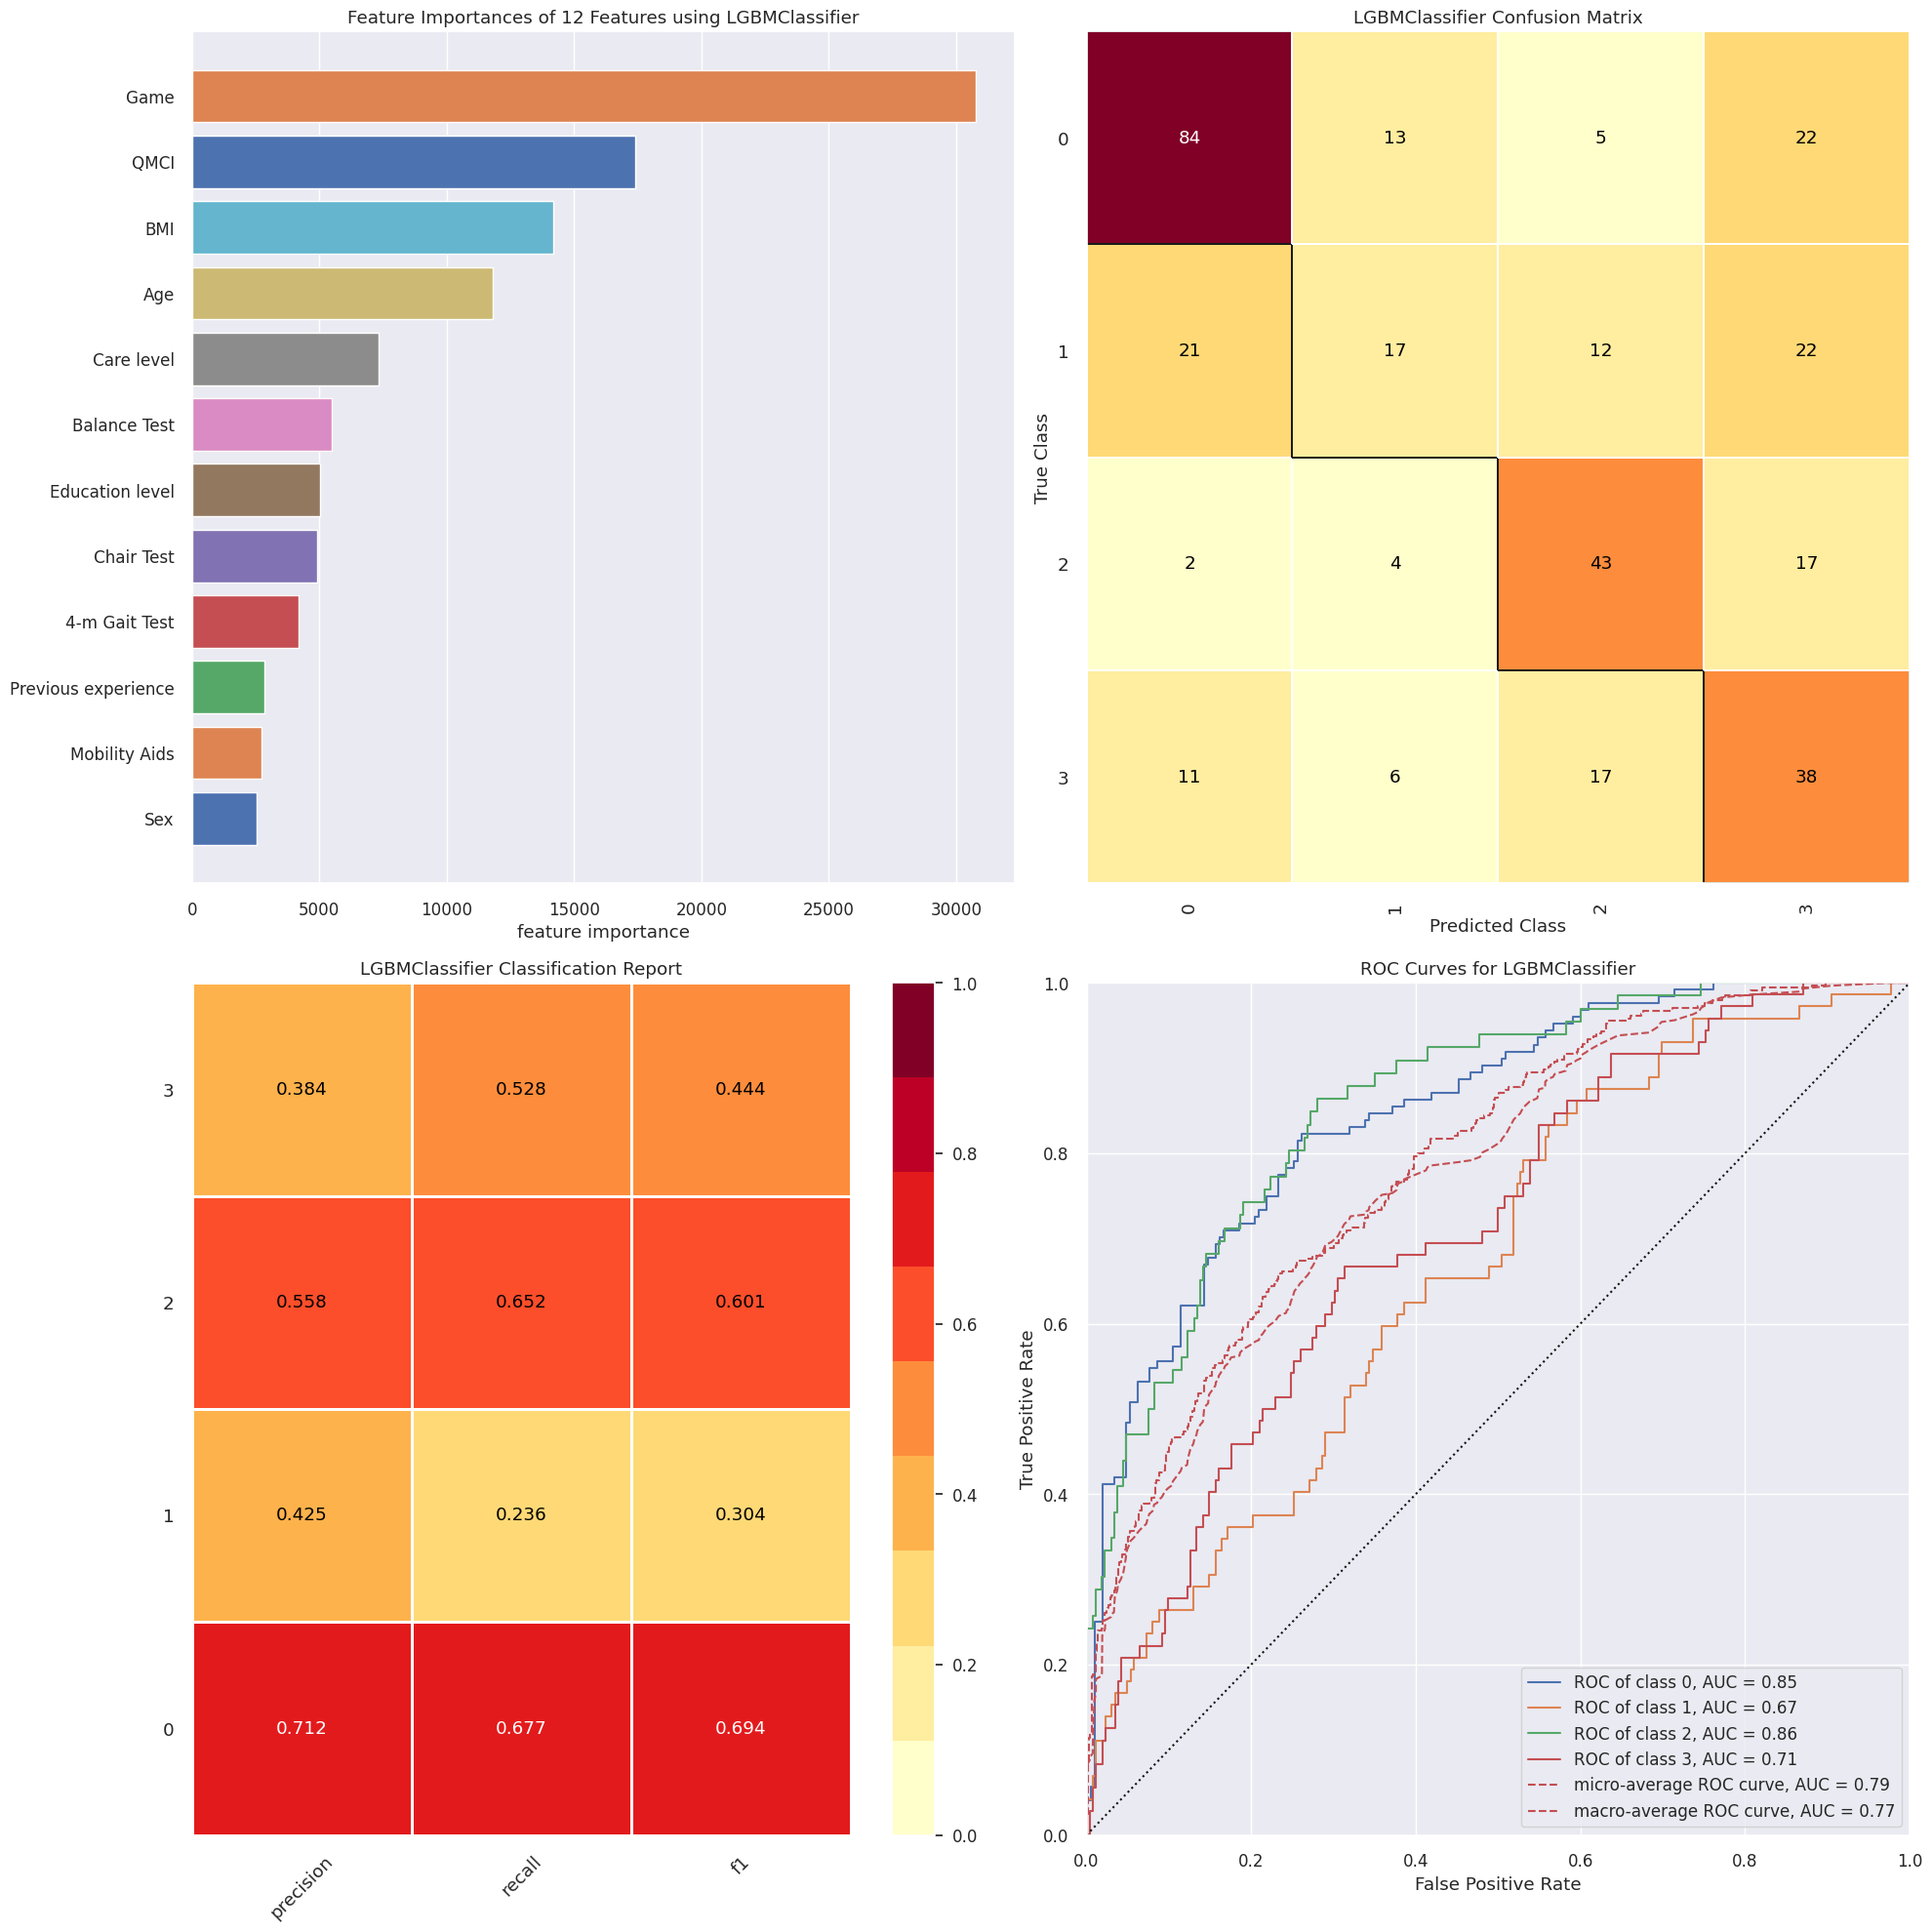

In [51]:
# Encode target
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit pipeline
lgbm_pipeline.fit(X_train, y_train_encoded)

# Preprocess data for FeatureImportances
X_train_transformed = lgbm_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = lgbm_pipeline.named_steps['preprocessor'].transform(X_test)

# Get full feature names
ohe = lgbm_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([continuous_features, ohe_feature_names])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Visualizers
visualgrid = [
    FeatureImportances(
        lgbm_pipeline.named_steps['lgbm'],
        ax=axes[0][0],
        labels=all_feature_names,
        relative=False,     # Prevents type error on int feature_importances_
        stack=False
    ),
    ConfusionMatrix(lgbm_pipeline, ax=axes[0][1]),
    ClassificationReport(lgbm_pipeline, ax=axes[1][0]),
    ROCAUC(lgbm_pipeline, ax=axes[1][1]),
]

# Fit and score visualizers
visualgrid[0].fit(X_train_transformed, y_train_encoded)
visualgrid[0].score(X_test_transformed, y_test_encoded)
visualgrid[0].finalize()

for viz in visualgrid[1:]:
    viz.fit(X_train, y_train_encoded)
    viz.score(X_test, y_test_encoded)
    viz.finalize()

plt.show()

# SHAP Evaluation

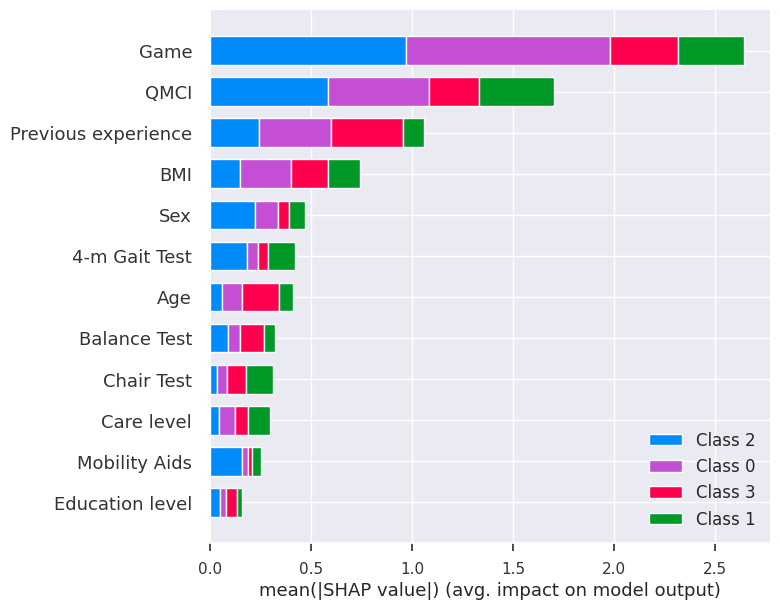

In [60]:
model = lgbm_pipeline.named_steps['lgbm']

explainer = shap.TreeExplainer(model, feature_perturbation='interventional')

# Use transformed data for SHAP
shap_values = explainer.shap_values(X_test_transformed, check_additivity=False)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Plot (fix layout + x-axis label)
plt.figure(figsize=(14, 6))  # make it wider so label fits
shap.summary_plot(
    shap_values,
    X_test_transformed_df,
    max_display=X_test_transformed_df.shape[1],
    plot_type="bar",
    show=False  # IMPORTANT: lets you adjust after SHAP draws the plot
)

ax = plt.gca()
ax.set_xlabel("mean(|SHAP value|) (avg. impact on model output)")  # shorter label (optional but helps)
plt.tight_layout()  # adjust padding so nothing is clipped
plt.show()

In [61]:
print(label_encoder.classes_)


['001' '011' '110' '111']


In [62]:
# Build dictionary with CV and Test results stacked vertically
lgbm_results_stacked = {
    "LGBM CV": {
        "ROC-AUC": round(roc_auc_score(oof_targets, oof_probas, multi_class='ovr'), 4),
        "Accuracy": round(accuracy_score(oof_targets, oof_preds), 4),
        "Precision": round(precision_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "Recall": round(recall_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "F1": round(f1_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
    },
    "LGBM Test": {
        "ROC-AUC": round(roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr'), 4),
        "Accuracy": round(accuracy_score(y_test_encoded, y_test_pred), 4),
        "Precision": round(precision_score(y_test_encoded, y_test_pred, average="weighted", zero_division=0), 4),
        "Recall": round(recall_score(y_test_encoded, y_test_pred, average="weighted", zero_division=0), 4),
        "F1": round(f1_score(y_test_encoded, y_test_pred, average="weighted", zero_division=0), 4),
    }
}

# Create DataFrame
lgbm_leaderboard_df = pd.DataFrame.from_dict(lgbm_results_stacked, orient='index')
print("\nLGBM Leaderboard (CV vs Test):")
print(lgbm_leaderboard_df)



LGBM Leaderboard (CV vs Test):
           ROC-AUC  Accuracy  Precision  Recall      F1
LGBM CV     0.7922    0.5514     0.5414  0.5514  0.5440
LGBM Test   0.7709    0.5449     0.5490  0.5449  0.5378
